In [3]:
# spreadingmind

import requests
import json
from lxml import html
from ncbiumls.authorization import authorization
from time import sleep
import matplotlib.pyplot as plt
%matplotlib inline


class UMLS(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(str(api_key))

    def askTerm(self, term, inputType='atom', includeObsolete='false', includeSuppressible='false',
                returnIdType='concept', searchType='words', pageNumber=1, pageSize=25):

#   TODO: Add option like dump, if enabled - save data, current page, page size
#   TODO: Write some messages on succesfull access, like pageNumber etc.

        """
        Description: retrives all records associted with the term, returns list of dicts,
                     each dict have keywords name,uri,ui,rootSource.


        :param term:                A human readable term, such as 'gestatational diabetes', or a code from a source
                                    vocabulary, such as 11687002 from SNOMEDCT_US.

        :param inputType:           Specifies the data type you are using as your search parameter.
                                    Valid values:  'atom', 'code','sourceConcept','sourceDescriptor','sourceUi','tty'
                                    Default value: 'atom'
                                    Usage Note:     Use 'sourceUi' if you aren't sure if the identifier you're providing
                                                    is a code, source concept, or source descriptor. Using 'tty' is for
                                                    advanced use cases and will extract codes from a specified
                                                    vocabulary according to term type.

        :param includeObsolete:     Return content that is a result of matches on obsolete terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param includeSuppressible: Return content that is a result of matches on suppressible terms.
                                    Valid values:   true or false
                                    Default value: 'false'

        :param returnIdType:        Specifies the type of identifier you wish to retrieve.
                                    Valid values:   true or false
                                    Default value: 'false'
                                    Usage Note:     Use 'code','sourceConcept', 'sourceDescriptor', or 'sourceUi' if you
                                                    prefer source-asserted identifiers rather than CUIs in your search
                                                    results.

        :param searchType:          Type of search you wish to use.
                                    Valid values:  'exact','words','leftTruncation', 'rightTruncation','approximate',
                                                   'normalizedString'
                                    Default value: 'words'
                                    Usage Note:     Use 'exact' when using inputType = 'code', 'sourceConcept',
                                                   'sourceDescriptor', or 'sourceUi'.

        :param pageNumber:          Whole number that specifies which page of results to fetch
                                    Valid values:   1,2,3, etc
                                    Default value:  1

        :param pageSize:            Whole number that specifies the number of results to include per page.
                                    Valid values:   1,2,3, etc
                                    Default value:  25

        :return:
        """
        # main url and parameters
        url = 'https://uts-ws.nlm.nih.gov/rest/search/current'
        params = {'ticket': '',
                  'string': str(term),
                  'inputType': inputType,
                  'includeObsolete': includeObsolete,
                  'includeSuppressible': includeSuppressible,
                  'returnIdType': returnIdType,
                  'searchType': searchType,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}

        #varible to store received data
        data = []

        #in case specific page is not provided - grab all results starting from page 1
        if pageNumber == 1:

            #function is guaranteed to return results so ask cycle will roll infinitely
            while True:

                #get a service ticket
                params['ticket'] = self.getST()

                #access page
                get = requests.get(url=url, params=params)
                try:

                    #if all the results obtained return gathered data
                    if get.json()['result'] == {'results': [{'ui': 'NONE', 'name': 'NO RESULTS'}],
                                                  'classType': 'searchResults'}:
                        return data

                    #else grab some more data
                    else:
                        for item in get.json()['result']['results']:
                            data.append(item)
                        params['pageNumber'] += 1

                #if server returned error - try to print that error, wait and retry request
                except Exception as exp:
                    response = html.fromstring(data.text)
                    print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                          ', current page number = ' + str(pageNumber),
                          ', current page size = ' + str(pageSize))

                #to not overlode server pause a bit
                sleep(0.5)

        #else access specific page
        else:
            params['ticket'] = self.getST()
            get = requests.get(url=url, params=params)
            try:
                return get.json()['result']['results']
            except Exception as exp:
                response = html.fromstring(data.text)
                print(response.xpath('.//p/b[contains(text(),"description")]/following::u')[0].text,
                      ', current page number = ' + str(pageNumber),
                      ', current page size = ' + str(pageSize))



class CUI(authorization):
    def __init__(self, api_key='e9990d5d-ff93-40f1-9f60-29ce7cf2950c'):
        super().__init__(api_key=api_key)

    def CUIGeneral(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUISemanticTypes(self, cui):
        """
        :param cui: The Concept Unique Identifier for a Metathesaurus concept
        :return: Returns dictionary processed from JSON, example:
                {
                    "pageSize": 25,
                    "pageNumber": 1,
                    "pageCount": 1,
                    "result": {
                        "classType": "Concept",
                        "ui": "C0009044",
                        "suppressible": false,
                        "dateAdded": "09-30-1990",
                        "majorRevisionDate": "08-18-2015",
                        "status": "R",
                        "semanticTypes": [
                            {
                                "name": "Injury or Poisoning",
                                "uri": "https://uts-ws.nlm.nih.gov/rest/semantic-network/2015AB/TUI/T037"
                            }
                        ],
                        "atomCount": 63,
                        "attributeCount": 0,
                        "cvMemberCount": 0,
                        "atoms": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/atoms",
                        "definitions": "NONE",
                        "relations": "https://uts-ws.nlm.nih.gov/rest/content/2015AB/CUI/C0009044/relations",
                        "defaultPreferredAtom": "https://uts-ws.nlm.nih.gov/rest/content/
                                                        2015AB/CUI/C0009044/atoms/preferred",
                        "relationCount": 5,
                        "name": "Closed fracture carpal bone"
                    }
                }
        """
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui)
        params = {'ticket': stTicket}
        data = requests.get(url=url, params=params)
        try:
            return data.json()['result']['semanticTypes']

        except Exception as exp:
            response = html.fromstring(data.text)
            return response.xpath('.//p/b[text()="message"]/u')

    def CUIAtoms(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/atoms'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIDefenitions(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/definitions'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

    def CUIRelations(self, cui, pageNumber=1, pageSize=25):
        stTicket = self.getST()
        url = 'https://uts-ws.nlm.nih.gov/rest/content/current/CUI/' + str(cui) + '/relations'
        params = {'ticket': stTicket,
                  'pageNumber': pageNumber,
                  'pageSize': pageSize}
        data = requests.get(url=url, params=params)
        pass

In [96]:
import os

data = {}

for i in os.listdir('data/'):
    print(i)
    year = int(i.split('.')[0])
    with open('data/{}'.format(i)) as data_file:
        data[year] = json.load(data_file)
        for i in ['chemicals', 'mesh_titles']:
            for key, val in data[year][i].items():
                data[year][i][key] = val/data[year]['count_articles']

1990.json
1993.json
1994.json
1995.json
1996.json
1997.json
1998.json
1999.json
2000.json
2001.json
2002.json
2003.json
2004.json
2006.json
2007.json
2008.json
2009.json


In [105]:
get_sorted(data[2009]['mesh_titles'])[:100]

[('humans', 0.912121995347635),
 ('aged', 0.459033341948824),
 ('male', 0.4481778237270613),
 ('female', 0.43318686999224604),
 ('animals', 0.30783148100284313),
 ('alzheimer disease/metabolism', 0.2708710261049367),
 ('aged, 80 and over', 0.26725252003101574),
 ('alzheimer disease/pathology', 0.2571723959679504),
 ('middle aged', 0.22667355905918843),
 ('alzheimer disease/physiopathology', 0.1910054277591109),
 ('alzheimer disease/genetics', 0.18531920392866374),
 ('alzheimer disease/drug therapy', 0.17446368570690102),
 ('amyloid beta-peptides/metabolism', 0.17006978547428275),
 ('alzheimer disease/diagnosis', 0.16283277332644094),
 ('mice', 0.15637115533729645),
 ('alzheimer disease/psychology', 0.14370638407857328),
 ('brain/pathology', 0.12483845955027138),
 ('neuropsychological tests', 0.12302920651331094),
 ('brain/metabolism', 0.11734298268286379),
 ('disease models, animal', 0.10338588782631171),
 ('mice, transgenic', 0.09614887567846989),
 ('alzheimer disease/epidemiology', 0

In [71]:
def get_sorted(p_dict):
    return sorted(p_dict.items(), key=lambda x: x[1], reverse=True)

def get_term_over_years(p_data, p_type, p_term):
    

In [ ]:
def 

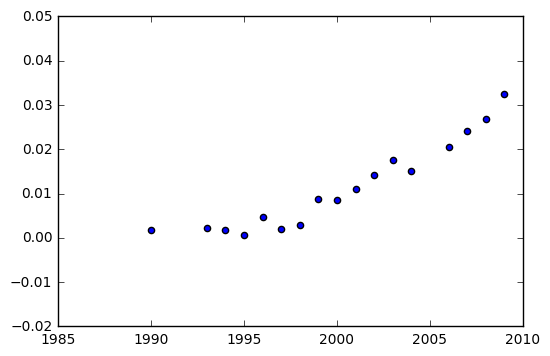

In [103]:
to_draw = []
inxs = []

for i in range(1990, 2018):
    if i in data:
        tmp = data[i]['mesh_titles']['mice, inbred c57bl']
        to_draw.append(tmp)
        inxs.append(i)
        
plt.figure()
plt.scatter(inxs, to_draw)

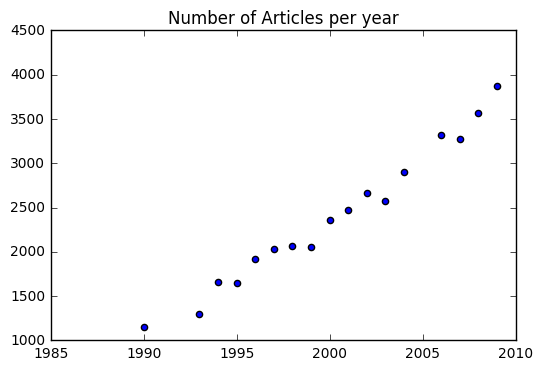

In [95]:
to_draw = []
inxs = []

for i in range(1990, 2018):
    if i in data:
        tmp = data[i]['count_articles']
        to_draw.append(tmp)
        inxs.append(i)
#         print(i, tmp)
        
plt.figure()
plt.scatter(inxs, to_draw)
plt.title('Number of Articles per year')

In [65]:
get_sorted(data[2003]['chemicals'])

[('a', 2649),
 ('l', 1766),
 ('b', 883),
 ('t', 883),
 ('n', 883),
 (']', 883),
 ('o', 883),
 ('[', 883),
 (' ', 883),
 ('e', 883),
 ('v', 883),
 ('i', 883),
 ('amyloid beta-peptides', 440),
 ('amyloid beta-protein precursor', 205),
 ('apolipoproteins e', 183),
 ('cholinesterase inhibitors', 182),
 ('peptide fragments', 177),
 ('membrane proteins', 138),
 ('tau proteins', 136),
 ('amyloid beta-protein (1-42)', 91),
 ('presenilin-1', 91),
 ('amyloid precursor protein secretases', 85),
 ('endopeptidases', 84),
 ('aspartic acid endopeptidases', 84),
 ('psen1 protein, human', 76),
 ('biomarkers', 75),
 ('bace1 protein, human', 70),
 ('neuroprotective agents', 69),
 ('indans', 68),
 ('piperidines', 67),
 ('nerve tissue proteins', 67),
 ('apolipoprotein e4', 64),
 ('donepezil', 63),
 ('amyloid beta-protein (1-40)', 60),
 ('rna, messenger', 53),
 ('cholesterol', 51),
 ('nootropic agents', 50),
 ('anti-inflammatory agents, non-steroidal', 45),
 ('antioxidants', 42),
 ('memantine', 41),
 ('enzy

In [13]:
data_umls = UMLS()

print(data_umls.getST())
print(data_umls.tgt.split('/')[-1])

ST-2449248-9MBklLIB7AdLMulMIpEy-cas
TGT-1008454-keND7cN9krcD45QJg4kuACxvpGosWDk4QcMFqcAXXTctomz31R-cas


In [40]:
data[2006]

{'chemicals': {'tetralones': 1,
  'toll-like receptors': 1,
  'guanine': 1,
  'aqp1 protein, human': 1,
  'escherichia coli proteins': 1,
  'tramiprosate': 2,
  'rho-associated kinases': 3,
  'solvents': 4,
  'estrogens': 25,
  'alanine transaminase': 1,
  'yellow fluorescent protein, bacteria': 1,
  'triazoles': 1,
  'colec12 protein, human': 1,
  'detergents': 2,
  'calnexin': 2,
  'morpholines': 1,
  'polyglutamine': 3,
  'mitochondrial permeability transition pore': 1,
  'abca1 protein, human': 3,
  'neuroprotective agents': 105,
  'metabotropic glutamate receptor 2': 1,
  'cib1 protein, rat': 1,
  'iron': 21,
  'dyrk kinase': 1,
  'glutamine': 1,
  'blood glucose': 2,
  'acetylcholine': 33,
  'adaptor proteins, vesicular transport': 3,
  'nestin': 2,
  'myelin basic protein': 1,
  'transcription factor ap-1': 1,
  'adam19 protein, human': 1,
  'dna, viral': 1,
  'cysteine proteinase inhibitors': 3,
  'receptors, death domain': 1,
  'methadone': 2,
  'tlr4 protein, mouse': 1,
  're

In [14]:
# m_term = 'proteins'
# m_term = 'alcoholism genetics'
# m_term = 'alzheimer disease'
# m_term = 'Alcoholism/genetics'
# m_term = 'kcnq1'
# m_term = 'amyloid beta peptides'
# m_term = 'potassium channels'
# m_term = 'Alzheimer'
# m_term = 'Pharmacologic Substance'
m_term = 'n(6)-cyclohexyladenosine'

m_dict_uis = {m_term: []} # term : ui
m_dict_ui_by_name = {}    # ui : term
m_dict_term_by_ui = {}

# res = data.askTerm(m_term, pageSize=100000, searchType='approximate')
res = data_umls.askTerm(m_term, pageSize=100000, searchType='exact')
# res = data.askTerm(m_term, pageSize=100000, inputType='tty', searchType='exact')

for i in res:
    print(i)
    ui = i['ui']
    name = i['name']
    if ui not in m_dict_ui_by_name:
        m_dict_ui_by_name[ui] = []
    m_dict_ui_by_name[ui].append(name)

    m_dict_uis[m_term].append(ui)
    if ui not in m_dict_term_by_ui:
        m_dict_term_by_ui[ui] = []
    m_dict_term_by_ui[ui].append(m_term)

print('--> m_dict_uis')
print(m_dict_uis)
print()

print('--> m_dict_term_by_ui')
print(m_dict_term_by_ui)
print()

print('--> m_dict_ui_by_name')
print(m_dict_ui_by_name)
print()

m_cui = CUI()

m_dict_sem_types = {} # ui : [name1, name2, ...]
m_dict_uis_by_st = {} # sem_type : [ui1, ui2, ...]

for ui in m_dict_uis[m_term]:
    query_res = m_cui.CUIGeneral(ui)
    print('----> ui: {}'.format(ui))
    for sem_type in query_res['result']['semanticTypes']:
        st_name = sem_type['name']

        if st_name not in m_dict_uis_by_st:
            m_dict_uis_by_st[st_name] = []
        m_dict_uis_by_st[st_name].append(ui)

        if ui not in m_dict_sem_types:
            m_dict_sem_types[ui] = []
        m_dict_sem_types[ui].append(st_name)
        print(sem_type)

print()
print('-----> m_dict_sem_types')
print(m_dict_sem_types)

print()
print('-----> m_dict_uis_by_st')
print(m_dict_uis_by_st)



{'uri': 'https://uts-ws.nlm.nih.gov/rest/content/2016AB/CUI/C0067223', 'name': 'N(6)-cyclohexyladenosine', 'ui': 'C0067223', 'rootSource': 'MSH'}
--> m_dict_uis
{'n(6)-cyclohexyladenosine': ['C0067223']}

--> m_dict_term_by_ui
{'C0067223': ['n(6)-cyclohexyladenosine']}

--> m_dict_ui_by_name
{'C0067223': ['N(6)-cyclohexyladenosine']}

----> ui: C0067223
{'name': 'Nucleic Acid, Nucleoside, or Nucleotide', 'uri': 'https://uts-ws.nlm.nih.gov/rest/semantic-network/2016AB/TUI/T114'}

-----> m_dict_sem_types
{'C0067223': ['Nucleic Acid, Nucleoside, or Nucleotide']}

-----> m_dict_uis_by_st
{'Nucleic Acid, Nucleoside, or Nucleotide': ['C0067223']}
